# Análise de dados de risco de fogo

## Objetivos

O objetivo principal é a obtenção do índice de risco de fogo para o Estado de São Paulo.

Também foi feito um algorítmo para extrair dados de foco de incêndio para as áreas de silvicultura do estado e comparar esses dados com índices de vegetação (NDVI, EVI e EVI2). Deste modo foi possível verificar a sazonalidade dos episódios de incêncio florestal e correlacionar com indicadores quali-quantitativos de biomassa.

## Metodologia

Esse notebook é dividido em duas partes:

[1 - Cálculo do risco de fogo](#Risco_de_Fogo)

- Google Earth Engine (GEE) para obtenção e análise de dados de sensoriamento remoto.
- Foi dada ênfase para áreas de silvicultura no Estado de São Paulo, porém as funções podem ser facilmente adaptadas para outros cenários e localidades.
- Fontes de dados:
    - Precipitação - [IMERG](https://developers.google.com/earth-engine/datasets/catalog/NASA_GPM_L3_IMERG_V06)
        - Resolução espacial: 11132 m
    - Temperatura e umidade relativa - [GFS]((https://developers.google.com/earth-engine/datasets/catalog/NOAA_GFS0P25?hl=en))
    - Focos de incêndio - [VIIRS](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_001_VNP14A1)
        - Resolução: 1000 m
        - Foram filtrados os dados para retornar apenas os classificados como 8 ou 9 ('Nominal confidence fire pixel' e 'High confidence fire')
        - Filtro para obter os focos dos 3 dias antecedentes à data da análise
    - Uso e ocupação do solo - [MapBiomas coleção 7 (2021)](https://mapbiomas.org/)
        - O recorte para o estado de São Paulo foi feito utilizando o toolkit do GEE disponibilizado pelos desenvolvedores.
    - Constante de flamabilidade
        - adaptado de Setzer et al. (2019)
        - Para as áreas de silvicultura foi utilizado o valor 4.
    - Modelo digital de elevação - [SRTM](https://developers.google.com/earth-engine/datasets/catalog/CGIAR_SRTM90_V4#bands)
        - Resolução horizontal: 90m

[2 - Focos de incêndio](#Focos_de_incendio)
- Fontes de dados:
Ambos para o período de **2017-01-01 a 2023-07-20** e recortados para as áreas de silvicultura com área superior a 200 ha.
    - Focos de incêndio - [VIIRS](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_001_VNP14A1)
        - Resolução: 1000 m
        - Foram filtrados os dados para retornar apenas os classificados como 8 ou 9 ('Nominal confidence fire pixel' e 'High confidence fire')
        - Tempo de processamento: 11:54:57 (705 polígonos)
    - Índices espectrais de vegetação - [SENTINEL](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2#description)
        - NDVI
        - EVI
        - EVI2


## Referências
- [Setzer et al. 2019. Método do cálculo do risco de fogo do programa do INPE](https://queimadas.dgi.inpe.br/~rqueimadas/documentos/RiscoFogo_Sucinto.pdf)


In [1]:
import geopandas as gpd
import ee
import geemap as gee
import datetime as dt
import numpy as np

import matplotlib.pyplot as plt
# ee.Authenticate()
gee.ee_initialize()

# Setup

In [2]:
begTime = dt.date.today()
today = ee.Date(begTime.strftime("%Y-%m-%d"))

# Read

In [3]:
df_uf = gpd.read_file('../data/vector/uf_sp.shp')
df_br =  gpd.read_file('../data/vector/br.shp')
# df_silvicultura = gpd.read_file('../data/vector/silvicultura_2021_clean50.shp')

In [4]:
silv = ee.FeatureCollection("projects/ee-lucaspontesm/assets/silvicultura_2021_clean50");

In [5]:
lulc = ee.Image("projects/ee-lucaspontesm/assets/MAPBIOMAS/mapbiomas-brazil-collection-71-saopaulo-2021")
gfs_collection = ee.ImageCollection('NOAA/GFS0P25')
imerg_collection = ee.ImageCollection("NASA/GPM_L3/IMERG_V06")
viirs_collection = ee.ImageCollection("NOAA/VIIRS/001/VNP14A1")
dem = ee.Image("CGIAR/SRTM90_V4")

In [6]:
aoi = ee.FeatureCollection("projects/ee-lucaspontesm/assets/uf_sp").geometry(); 

# Risco_de_Fogo
## UDF

In [7]:
flame_cte = {1: ["Forest", 2],
            2: ["Natural Forest", 2],
            3: ["Forest Formation", 2],
            4: ["Savanna Formation", 2.4],
            5: ["Magrove", 1.5],
            6: ["Áreas Naturales Inundables - Leñosas (Bosque Inundable)",1.5],
            9: ["Forest Plantation", 4],
            10: ["Non Forest Natural Formation", 2],
            11: ["Wetland",1.5],
            12: ["Grassland (Pastizal, Formación Herbácea)", 6],
            13: ["Other Non Forest Natural Formation", 2],
            14: ["Farming", 4],
            15: ["Pasture", 6],
            18: ["Agriculture",4],
            19: ["Temporary Crops (Herbaceas - Agricultura)",4],
            20: ["Sugar Cane",4],
            21: ["Mosaic of Agriculture and Pasture",5],
            # 22: ["Non vegetated area",None],
            # 23: ["Beach and Dune",None],
            # 24: ["Urban Infrastructure", None],
            # 25: ["Other Non Vegetated Area", None],
            # 26: ["Water", None],
            # 27: "Non Observed",
            # 29: ["Rocky outcrop", None],
            # 30: ["Mining", None],
            # 31: ["Aquaculture", None],
            # 32: "Salt flat",
            # 33: ["River, Lake and Ocean", None],
            # 34: ["Glacier", None],
            35: ["Oil Palm",4],
            36: ["Perennial Crops",3],
            # 37: ["Artificial Water Body", None],
            # 38: ["Water Reservoirs", None],
            39: ["Soy Beans",4],
            40: ["Rice",4],
            41: ["Mosaic of Crops",4],
            46: ['Coffe',4],
            47: ['Citrus',4],
            48: ['Other Perennial Crops', 4],
            49: ['Wooded Sandbank Vegetation', 3],
            50: ['Herbaceous Sandbank Vegetation', 3],
            62: ["Cotton", 4],
            # 0: "Non Observed"
            }

# Pre-processamento

In [8]:
# https://developers.google.com/earth-engine/apidocs/ee-image-remap
# A list of pixel values to replace.
fromList = list(flame_cte.keys())

# A corresponding list of replacement values (1 becomes 1, 2 becomes 2, etc).
toList = [x[1] for x in flame_cte.values()]

# Replace pixel values in the image. If the image is multi-band, only the
# remapped band will be returned. The returned band name is "remapped".
# Input image properties are retained in the output image.
flamability = lulc.remap(**{
  'from': fromList,
  'to': toList,
  'defaultValue': None,
  'bandName': 'b1'
})

In [9]:
# flamability.reduceRegion(**{
#                     'reducer': ee.Reducer.min(),
#                     'scale': 11000,
#     }).getInfo()

# IMERG rainfall

In [10]:
# iteração para pegar a imagem de chuva mais recente
p1 = (imerg_collection
      .filterDate((begTime - dt.timedelta(days=1)).strftime("%Y-%m-%d"),
                   begTime.strftime("%Y-%m-%d"))
        .select('precipitationCal')
        .sum()
        .clip(aoi))

while len(p1.getInfo()['bands']) == 0:
      begTime = (begTime - dt.timedelta(days=1))
      today = ee.Date(begTime.strftime("%Y-%m-%d"))

      p1 = (imerg_collection
            .filterDate((begTime - dt.timedelta(days=1)).strftime("%Y-%m-%d"),
                        begTime.strftime("%Y-%m-%d"))
            .select('precipitationCal')
            .sum()
            .clip(aoi))

In [11]:
p2 = (imerg_collection
      .filterDate((begTime - dt.timedelta(days=2)).strftime("%Y-%m-%d"),
                   begTime.strftime("%Y-%m-%d"))
        .select('precipitationCal')
        .sum()
        .clip(aoi))

p3 = (imerg_collection
      .filterDate((begTime - dt.timedelta(days=3)).strftime("%Y-%m-%d"),
                   begTime.strftime("%Y-%m-%d"))
        .select('precipitationCal')
        .sum()
        .clip(aoi))

p4 = (imerg_collection
      .filterDate((begTime - dt.timedelta(days=4)).strftime("%Y-%m-%d"),
                   begTime.strftime("%Y-%m-%d"))
        .select('precipitationCal')
        .sum()
        .clip(aoi))

p5 = (imerg_collection
      .filterDate((begTime - dt.timedelta(days=5)).strftime("%Y-%m-%d"),
                   begTime.strftime("%Y-%m-%d"))
        .select('precipitationCal')
        .sum()
        .clip(aoi))
p10 = (imerg_collection
      .filterDate((begTime - dt.timedelta(days=10)).strftime("%Y-%m-%d"),
                   begTime.strftime("%Y-%m-%d"))
        .select('precipitationCal')
        .sum()
        .clip(aoi))
p15 = (imerg_collection
      .filterDate((begTime - dt.timedelta(days=15)).strftime("%Y-%m-%d"),
                   begTime.strftime("%Y-%m-%d"))
        .select('precipitationCal')
        .sum()
        .clip(aoi))
p30 = (imerg_collection
      .filterDate((begTime - dt.timedelta(days=30)).strftime("%Y-%m-%d"),
                   begTime.strftime("%Y-%m-%d"))
        .select('precipitationCal')
        .sum()
        .clip(aoi))
p60 = (imerg_collection
      .filterDate((begTime - dt.timedelta(days=60)).strftime("%Y-%m-%d"),
                   begTime.strftime("%Y-%m-%d"))
        .select('precipitationCal')
        .sum()
        .clip(aoi))
p90 = (imerg_collection
      .filterDate((begTime - dt.timedelta(days=90)).strftime("%Y-%m-%d"),
                   begTime.strftime("%Y-%m-%d"))
        .select('precipitationCal')
        .sum()
        .clip(aoi))
p120 = (imerg_collection
      .filterDate((begTime - dt.timedelta(days=120)).strftime("%Y-%m-%d"),
                   begTime.strftime("%Y-%m-%d"))
        .select('precipitationCal')
        .sum()
        .clip(aoi))

In [12]:
# p120.reduceRegion(**{
#                     'reducer': ee.Reducer.max(), 
#                     'geometry': aoi, 
#                     'scale': 11000,
#     }).getInfo()

In [13]:
fp1 = p1.expression('exp(-0.14 *p1)',
                    {'p1': p1.select('precipitationCal')})

fp2 = p2.expression('exp(-0.07 *(pf-pi))',
                    {'pi': p1.select('precipitationCal'),
                     'pf': p2.select('precipitationCal')})

fp3 = p3.expression('exp(c *(pf-pi))',
                    {'c':-0.04,
                    'pi': p2.select('precipitationCal'),
                    'pf': p3.select('precipitationCal')})

fp4 = p4.expression('exp(c *(pf-pi))',
                    {'c':-0.03,
                    'pi': p3.select('precipitationCal'),
                    'pf': p4.select('precipitationCal')})

fp5 = p5.expression('exp(c *(pf-pi))',
                    {'c':-0.02,
                    'pi': p4.select('precipitationCal'),
                    'pf': p5.select('precipitationCal')})

fp6a10 = p10.expression('exp(c *(pf-pi))',
                    {'c':-0.01,
                    'pi': p5.select('precipitationCal'),
                    'pf': p10.select('precipitationCal')})

fp11a15 = p15.expression('exp(c *(pf-pi))',
                    {'c':-0.008,
                    'pi': p10.select('precipitationCal'),
                    'pf': p15.select('precipitationCal')})

fp16a30 = p30.expression('exp(c *(pf-pi))',
                    {'c':-0.004,
                    'pi': p15.select('precipitationCal'),
                    'pf': p30.select('precipitationCal')})

fp31a60 = p60.expression('exp(c *(pf-pi))',
                    {'c':-0.002,
                    'pi': p30.select('precipitationCal'),
                    'pf': p60.select('precipitationCal')})

fp61a90 = p90.expression('exp(c *(pf-pi))',
                    {'c':-0.001,
                    'pi': p60.select('precipitationCal'),
                    'pf': p90.select('precipitationCal')})

fp91a120 = p120.expression('exp(c *(pf-pi))',
                    {'c':-0.0007,
                    'pi': p90.select('precipitationCal'),
                    'pf': p120.select('precipitationCal')})

In [14]:
# Calcula os dias de secura (PSE)
pse = (fp1
        .multiply(fp2)
        .multiply(fp3)
        .multiply(fp4)
        .multiply(fp5)
        .multiply(fp6a10)
        .multiply(fp11a15)
        .multiply(fp16a30)
        .multiply(fp31a60)
        .multiply(fp61a90)
        .multiply(fp91a120)
        .multiply(105)
)

In [15]:
# pse.reduceRegion(**{
#                     'reducer': ee.Reducer.min(), 
#                     'geometry': aoi, 
#                     'scale': 11000,
#     }).getInfo()

In [16]:
# calcula o Risco Basico de fogo (Rb)

rb = pse.expression('0.8*(1+sin((((a*pse)-90))*(3.14/180)))/2',
                    {'a':flamability.select('remapped'),
                    'pse': pse.select('constant')
                    })

In [17]:
# rb.reduceRegion(**{
#                     'reducer': ee.Reducer.max(), 
#                     'geometry': aoi, 
#                     'scale': 11000,
#     }).getInfo()

# GFS

In [18]:
# Map = gee.Map()
# temperatureAboveGround = gfs_collection.filter(ee.Filter.date('2023-07-17', '2023-07-18')).select('temperature_2m_above_ground').filterBounds(br).first()
# palette =  ['blue', 'purple', 'cyan', 'green', 'yellow', 'red']
# temperature_vis = {'min': -40.0, 'max': 35.0, 'palette': palette}

# Map.setCenter(-40, -10, 4)
# Map.addLayer(temperatureAboveGround, temperature_vis, 'Temperature Above Ground')
# Map

In [19]:
temperature = gfs_collection.filter(ee.Filter.date(begTime.strftime("%Y-%m-%d"))).select('temperature_2m_above_ground').filterBounds(aoi).max()
relative_humidity = gfs_collection.filter(ee.Filter.date(begTime.strftime("%Y-%m-%d"))).select('relative_humidity_2m_above_ground').filterBounds(aoi).min()

In [20]:
ft = temperature.expression('(Tmax*0.02)+0.4',
                            {'Tmax': temperature})

In [21]:
fu = relative_humidity.expression('(UR * -0.006)+1.3',
                                {'UR':relative_humidity})

# Risco de Fogo Observado

In [22]:
rf = rb.multiply(ft).multiply(fu)

In [23]:
flat = rf.expression('1+abs(lat)*0.003', {'lat':rf.pixelLonLat().select('latitude')})
felv = dem.expression('1+alt*0.00003', {'alt':dem.select('elevation')})

In [24]:
rfb = rf.multiply(flat).multiply(felv)

#  Focos de incêndio

In [25]:
#pode ocorrer de não existirem dados de queimada
if viirs_collection.filterDate(today.advance(-3, 'day'), today).size().getInfo() == 0:
    rfb_ajustado= rfb
else:   
  focos = (viirs_collection
    .filterDate(today.advance(-3, 'day'), today)
    .select('FireMask').max().gt(7).clip(aoi)
    .remap(**{
          'from': [0,1],
          'to': [1,2],
          'defaultValue': None,
          'bandName': 'FireMask'
          })
  )

  rfb_ajustado = rfb.multiply(focos)

# Classificação do risco de fogo

In [26]:
rf_class = (ee.Image(1)
      .where(rfb_ajustado.lte(0.15), 1)
      .where((rfb_ajustado.gt(0.15)).And(rfb_ajustado.lte(0.40)), 2)
      .where((rfb_ajustado.gt(0.40)).And(rfb_ajustado.lte(0.70)), 3)
      .where((rfb_ajustado.gt(0.70)).And(rfb_ajustado.lte(0.95)), 4)
      .where(rfb_ajustado.gt(0.95), 5)).clip(aoi)

# Resultado


In [27]:
Map = gee.Map()

palette = [
        '000096','0064ff', '00b4ff', '33db80', '9beb4a',
        'ffeb00', 'ffb300', 'ff6400', 'eb1e00', 'af0000'
        ]

precipitationVis = {'min': 0, 'max': 100, 'palette': palette}
vis_classe_fogo = {'min': 1, 'max': 5, 'palette': ['green', 'lime', 'yellow', 'red', 'maroon']}

Map.addLayer(pse, precipitationVis, 'Dias de Secura (PSE)')
Map.addLayer(rf, vis_classe_fogo, 'Risco de Fogo Observado')
Map.addLayer(silv, {},'Áreas de silvicultura')
Map.setCenter(-48, -24.5, 6.48) 
Map

# Focos_de_incendio

In [ ]:
import pandas as pd

In [ ]:
df_ndvi = pd.read_csv('../data/ndvi.csv')
df_viirs = pd.read_csv('../data/viirs.csv')

# Tratamentos

In [ ]:
df_viirs['date'] = pd.to_datetime(df_viirs['date'])
df_ndvi['date'] = pd.to_datetime(df_ndvi['date'])

In [ ]:
df_viirs['fid'] = df_viirs['fid'].astype(int)
df_ndvi['fid'] = df_ndvi['fid'].astype(int)

In [ ]:
# Filtra focos confirmados
df_viirs_fire = (df_viirs
                 [df_viirs['FireMask']>7]
                 .groupby(['fid', 'date'])
                 .agg(qtd_focos = ('fid', 'count'),
                      frp = ('MeanMaxFRP', 'mean'))
                 .reset_index())

In [ ]:
df_ndvi_full_date = (pd.DataFrame(pd.date_range(start='2017-01-01', end='2023-07-20'), columns=['date'])
            .merge(df_ndvi.groupby(['fid', 'date']).mean().reset_index(), on = 'date',how='left'))

In [ ]:
df = df_ndvi_full_date.merge(df_viirs_fire, on=['fid', 'date'], how='left').dropna(how='all', subset=['fid'])
df['qtd_focos'] = df['qtd_focos'].fillna(0)
df['frp'] = df['frp'].fillna(0)

# Correlação

In [ ]:
df_corr = (df[df['qtd_focos']>0].drop(columns=['fid'])
           .groupby('date')
           .agg(qtd_focos = ('qtd_focos', 'sum'),
               frp = ('frp', 'mean'),
               ndvi = ('ndvi', 'mean'),
               evi = ('evi', 'mean'),
               evi2 = ('evi2', 'mean')
               )
          .reset_index())

C:\Users\lucas.pontes\AppData\Local\Temp\ipykernel_11500\2594809411.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df_corr.corr(), fignum=f.number)


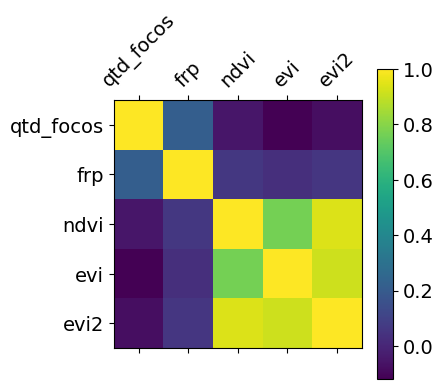

In [ ]:
f = plt.figure(figsize=(4, 4))
plt.matshow(df_corr.corr(), fignum=f.number)
plt.xticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16);

In [ ]:
df_corr.corr()

C:\Users\lucas.pontes\AppData\Local\Temp\ipykernel_11500\191381569.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr.corr()


,qtd_focos,frp,ndvi,evi,evi2
qtd_focos,1.000000,0.214766,-0.050117,-0.119602,-0.077921
frp,0.214766,1.000000,0.062818,0.030102,0.055634
ndvi,-0.050117,0.062818,1.000000,0.764662,0.941226
evi,-0.119602,0.030102,0.764662,1.000000,0.913958
evi2,-0.077921,0.055634,0.941226,0.913958,1.000000


# Plots

C:\Users\lucas.pontes\AppData\Local\Temp\ipykernel_11500\649752656.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_interanual = df.groupby(df['date'].dt.year).sum()['qtd_focos']


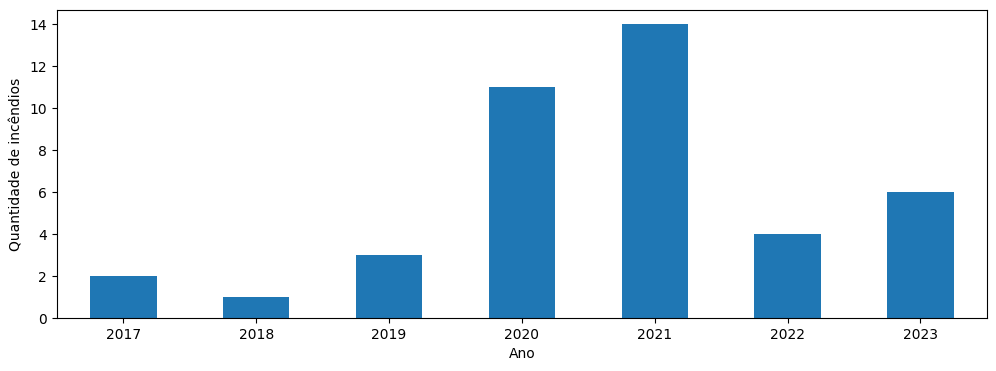

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))

df_interanual = df.groupby(df['date'].dt.year).sum()['qtd_focos']
# errors = df_interanual.std()
df_interanual.plot(kind='bar', rot=0, ax=axs, capsize=4)

plt.xlabel("Ano");  # custom x label using Matplotlib
plt.ylabel("Quantidade de incêndios");

C:\Users\lucas.pontes\AppData\Local\Temp\ipykernel_11500\3419517135.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mensal = df.groupby(df['date'].dt.month).sum()['qtd_focos']


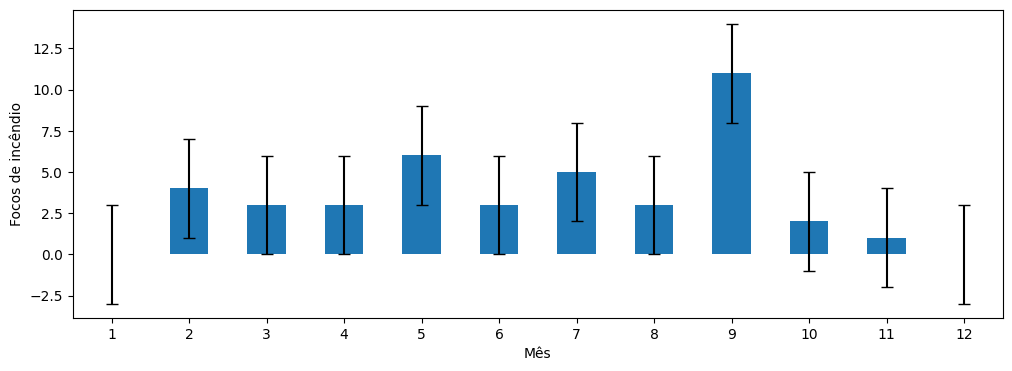

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))

df_mensal = df.groupby(df['date'].dt.month).sum()['qtd_focos']
errors = df_mensal.std()
df_mensal.plot(kind='bar', rot=0, ax=axs,yerr=errors, capsize=4)

plt.xlabel("Mês");  # custom x label using Matplotlib
plt.ylabel("Focos de incêndio");

C:\Users\lucas.pontes\AppData\Local\Temp\ipykernel_11500\1182253522.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mensal = df.groupby(df['date'].dt.month).mean()['evi']


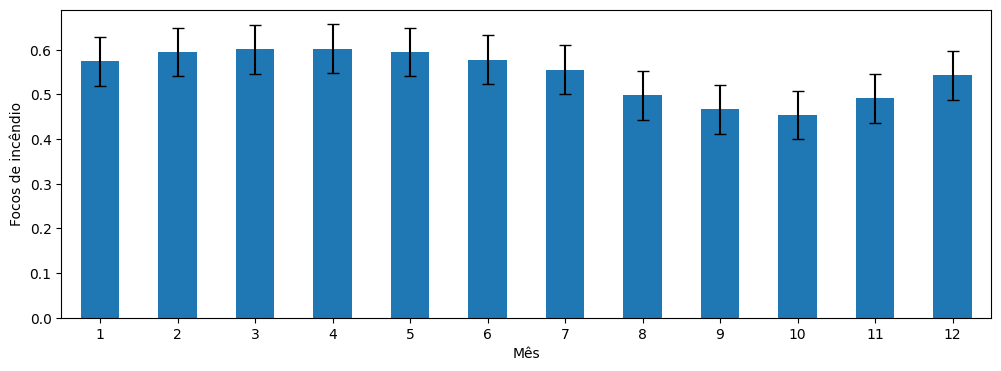

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))

df_mensal = df.groupby(df['date'].dt.month).mean()['evi']
errors = df_mensal.std()
df_mensal.plot(kind='bar', rot=0, ax=axs,yerr=errors, capsize=4)

plt.xlabel("Mês");  # custom x label using Matplotlib
plt.ylabel("Focos de incêndio");

C:\Users\lucas.pontes\AppData\Local\Temp\ipykernel_11500\2930212941.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mensal = df.groupby(df['date'].dt.month).mean()['ndvi']


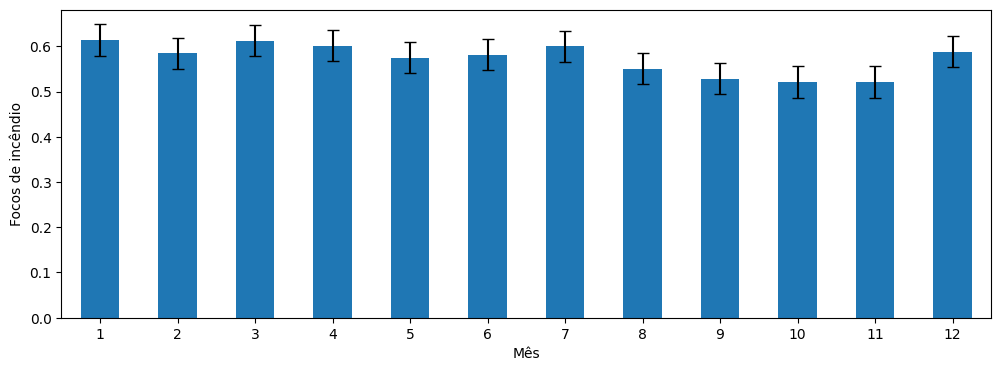

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))

df_mensal = df.groupby(df['date'].dt.month).mean()['ndvi']
errors = df_mensal.std()
df_mensal.plot(kind='bar', rot=0, ax=axs,yerr=errors, capsize=4)

plt.xlabel("Mês");  # custom x label using Matplotlib
plt.ylabel("Focos de incêndio");

<Axes: xlabel='date'>

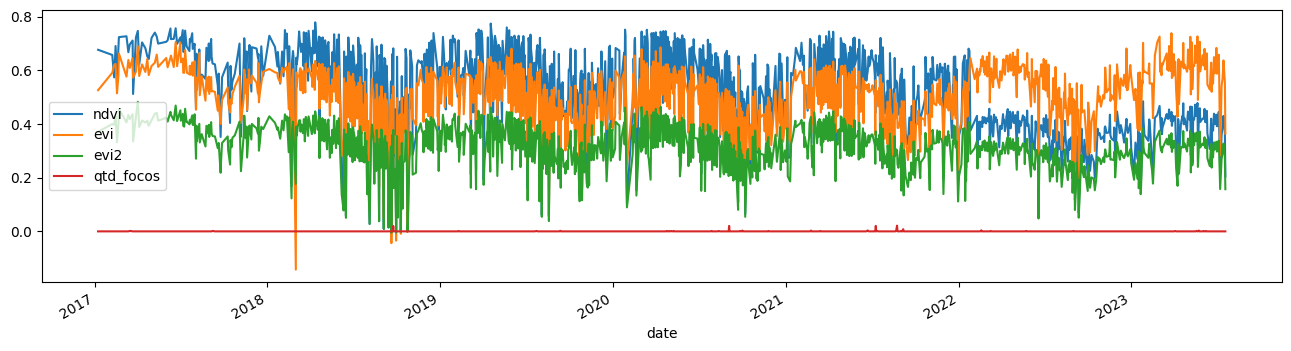

In [ ]:
df.drop(columns=['fid', 'frp']).groupby(['date']).mean().plot(figsize=(16,4))

<Axes: xlabel='date'>

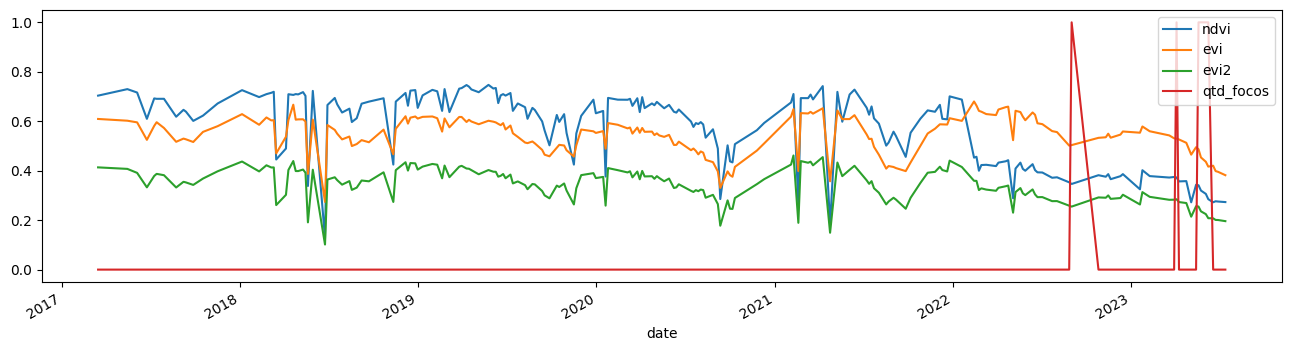

In [ ]:
df[df.fid==101172.0].drop(columns=['fid', 'frp']).groupby(['date']).mean().plot(figsize=(16,4))